## Instruction Finetuning

The goal of this section is to finetune the GPT LLM to follow instructions.

Currently our LLM is only capable of generating the next word given a sequence of words. However, our LLM struggles with following instructions such as: "sum the following two numbers: 4, 3." 

## Dataset

We need a dataset of instruction-response pairs. We are going to use the open-platypus dataset: [dataset](https://huggingface.co/datasets/garage-bAInd/Open-Platypus). The purpose of this dataset is to improve an LLM's logical reasoning skills. The dataset is comprised of the following datasets, which were filtered using keyword search and then Sentence Transformers to remove questions with similarity above 80%.

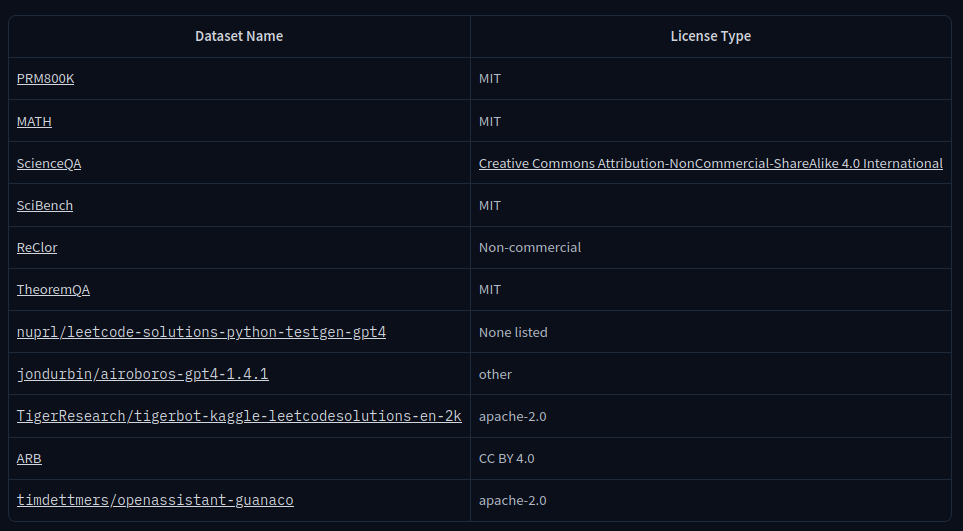

Moreover 200 questions that appear in the Hugging Face benchmark test sets were removed.

In [1]:
import os
os.chdir("../")

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import torch
torch.cuda.empty_cache()
print(torch.cuda.is_available(), torch.cuda.get_device_name(0))
free, total = torch.cuda.mem_get_info()
print(f"Free: {free/1024**2:.0f} MiB  Total: {total/1024**2:.0f} MiB")

import pandas as pd

# Let's import the dataset
df = pd.read_parquet("hf://datasets/garage-bAInd/Open-Platypus/data/train-00000-of-00001-4fe2df04669d1669.parquet")

True NVIDIA GeForce RTX 4050 Laptop GPU
Free: 5805 MiB  Total: 5898 MiB


/home/armando-albornoz/Desktop/resumeProjects/LLM_Project/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now that we have the data as a table we can look at some random rows

In [2]:
df.head()

,input,output,instruction,data_source
0,,To find the probability of the spinner landing...,A board game spinner is divided into three par...,MATH/PRM-800K
1,,"I need to choose 6 people out of 14, and the o...",My school's math club has 6 boys and 8 girls. ...,MATH/PRM-800K
2,,First we count the number of all 4-letter word...,How many 4-letter words with at least one cons...,MATH/PRM-800K
3,,She can do this if and only if at least one of...,Melinda will roll two standard six-sided dice ...,MATH/PRM-800K
4,,Think of the problem as a sequence of H's and ...,"Let $p$ be the probability that, in the proces...",MATH/PRM-800K


As we can see, the dataset is comprised of tuples of the following form: (input, output, instruction, data_source). Let's now get a random row.

In [3]:
# Return a random sample of items from an axis of object (for example rows). 
df.sample(n=1) 

,input,output,instruction,data_source
9708,,"From the given equation, $\cos x = \frac{1}{2}...",If $0^\circ < x < 180^\circ$ and $\cos x + \si...,MATH/PRM-800K


Next, let's check some statistics for word count of each column

In [4]:
for col in ["instruction", "input", "output"]:
    lengths = df[col].astype(str).str.split().str.len() ##
    print(f"\nColumn: {col} (word counts)")
    print(lengths.describe())


Column: instruction (word counts)
count    24926.000000
mean        88.727433
std        111.330669
min          2.000000
25%         21.000000
50%         41.000000
75%        136.000000
max       1640.000000
Name: instruction, dtype: float64

Column: input (word counts)
count    24926.000000
mean         2.114700
std          7.822599
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        194.000000
Name: input, dtype: float64

Column: output (word counts)
count    24926.000000
mean       106.864519
std        120.154827
min          1.000000
25%          3.000000
50%         76.000000
75%        151.000000
max       1547.000000
Name: output, dtype: float64


As we can see we have some outliers. We want to remove these in order ot be able to fit the whole instruction in our context.

In [5]:
df["total_words"] = (
    df["instruction"].astype(str).str.split().str.len() +
    df["input"].astype(str).str.split().str.len() +
    df["output"].astype(str).str.split().str.len()
)

print(df["total_words"].describe())

count    24926.000000
mean       197.706652
std        141.964037
min          3.000000
25%        110.000000
50%        165.000000
75%        237.000000
max       2038.000000
Name: total_words, dtype: float64


Let's now drop some rows

In [6]:
df_filtered = df[df["total_words"] <= 800]

print("Before:", len(df))
print("After:", len(df_filtered))
print(df_filtered["total_words"].describe())

Before: 24926
After: 24735
count    24735.000000
mean       191.799030
std        124.633957
min          3.000000
25%        110.000000
50%        164.000000
75%        235.000000
max        799.000000
Name: total_words, dtype: float64


Now, instruction finetuning involves training a model where the input-output pairs are already given. There are various methods to format these entries for LLMs.  The figure below illustrates two different methods:

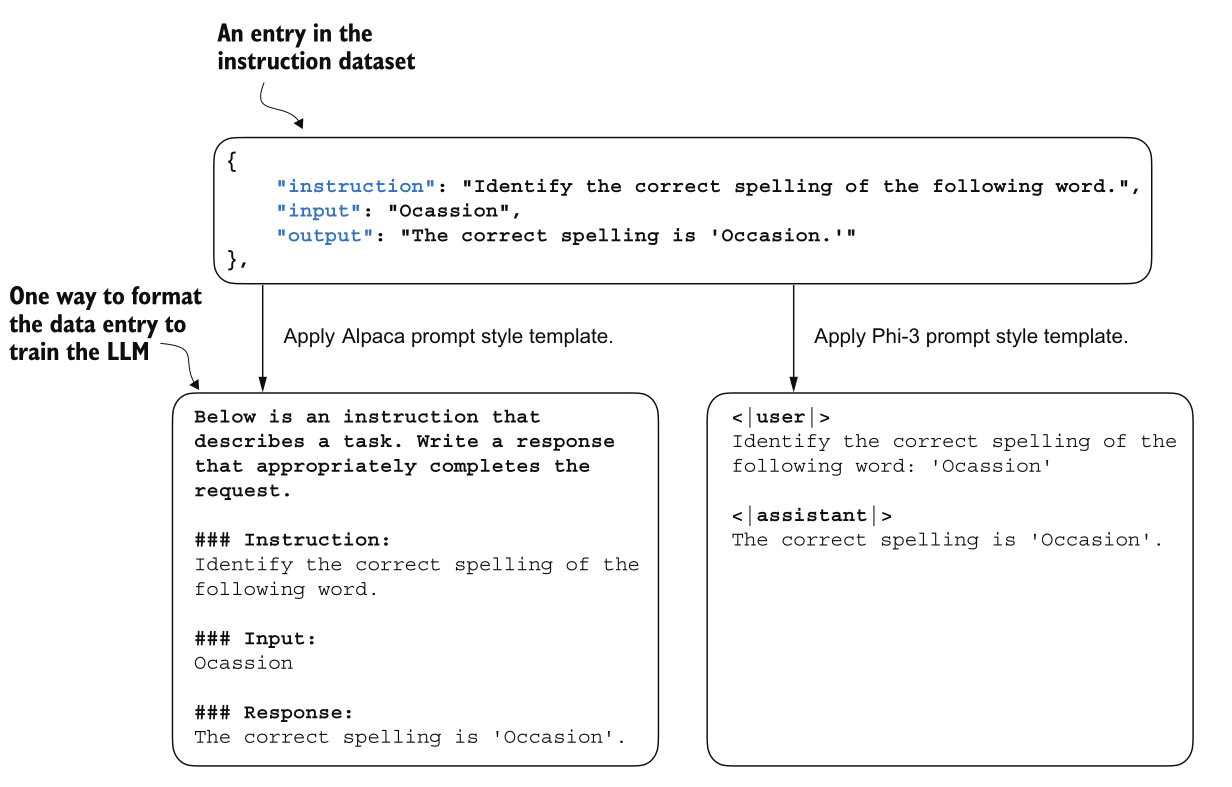

We are going to use the alpaca template since from what it can be seen from our dataset we already have instruction, input and response. Let's now develop a function that will format our input:

In [7]:
def format_input(entry):
    instruction = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input = (
        f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    )
    return instruction + input

Let's split our dataset into train, test and validation sets

In [8]:
num_rows = df_filtered.shape[0]

train_portion = int(num_rows * 0.9)
test_portion = int(num_rows* 0.05)
val_portion = num_rows - train_portion - test_portion

train_data = df_filtered.iloc[:train_portion]
test_data = df_filtered.iloc[train_portion: train_portion + test_portion]
val_data = df_filtered.iloc[train_portion + test_portion:]

print("Training set size:", len(train_data))
print("Validation set size:", len(val_data))
print("Test set size:", len(test_data))

Training set size: 22261
Validation set size: 1238
Test set size: 1236


As usual since our goal is to train a model, we need to first create a dataloader that will allow us to iterate over batches of our data. The first step towards this goal is to batch the dataset. Before, when we were pretraining the model, the batches were automatically created by the PyTorch DataLoader class, which has a default **collate** function to combine lists of samples into batches. The purpose of the collate function is to take a list of individual data samples and merge them into a single batch that can be processed by the model during training.

The batching process is illustrated below:

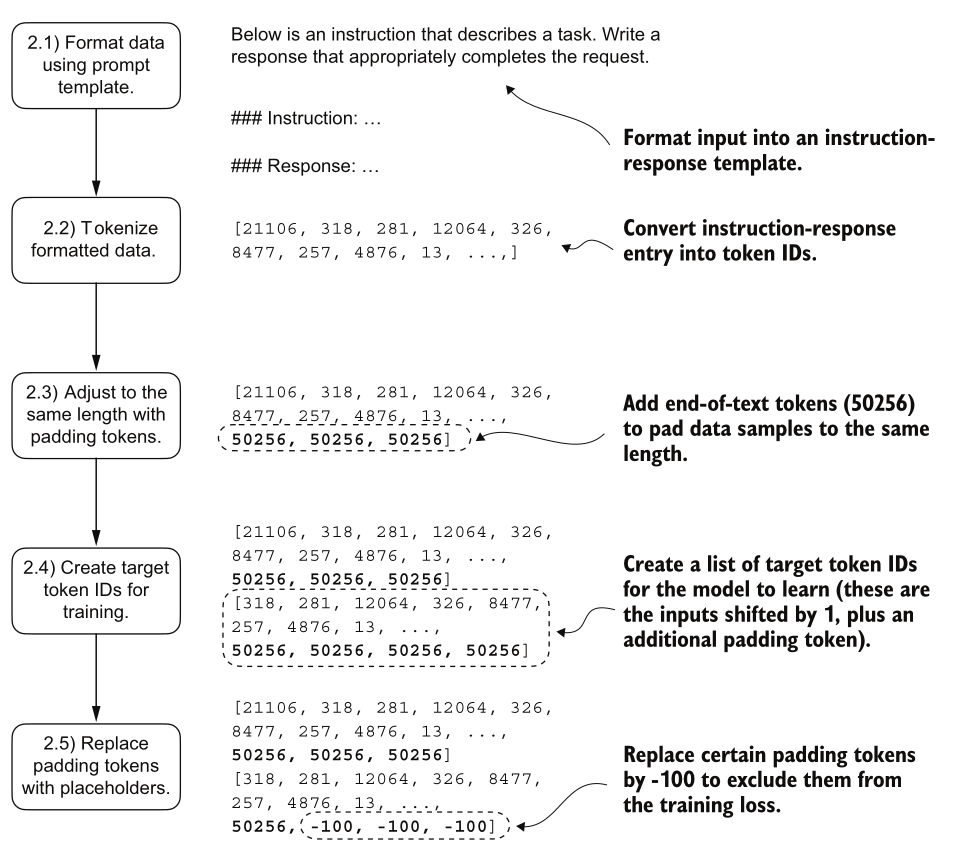

In [9]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenized_data = []

        for entry in data:
            formated_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = formated_input + response_text
            self.tokenized_data.append(tokenizer.encode(full_text))
        
    def __getitem__(self, index):
        return self.tokenized_data[index]

    def __len__(self):
        return len(self.data)

In order to perform the batching we need to pad all inputs to a similar length. We will use the <|endoftext|> token as a padding token. 


Let's now develop the collate function. This collate function will pad the training examples in each batch to the same length while allowing different batches to have different lengths. Below is an illustration of the process.

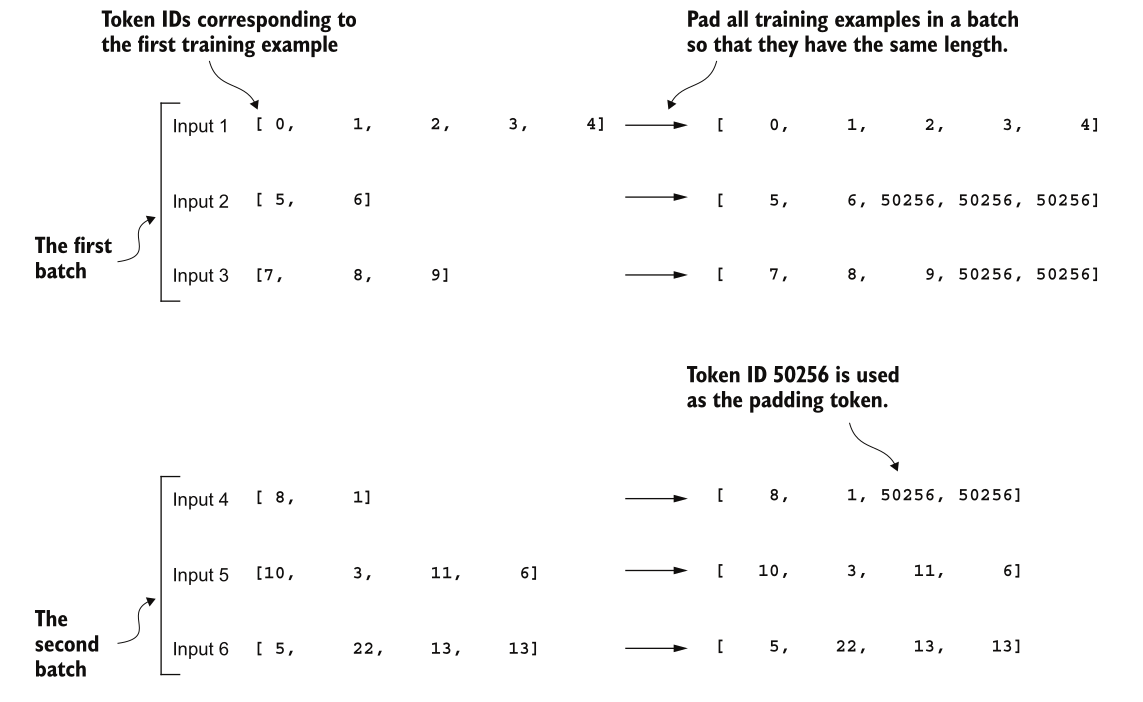

In [10]:
def collate(batch,pad_token_id=50256, device="cpu"):
    batch_max_length = max(len(item) + 1 for item in batch)
    inputs_list = []

    ## Padding
    for item in batch:
        new_item = item.copy()

        #That extra pad ensures the shifted targets are well-defined even for the last element.
        # If you didn’t add it, the final token wouldn’t have a target aligned with it.

        new_item += [pad_token_id] 

        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        inputs = torch.tensor(padded[:-1])
        inputs_list.append(inputs)

    inputs_tensor = torch.stack(inputs_list).to(device)
    return inputs_tensor

We now need to create batches with the target token IDs

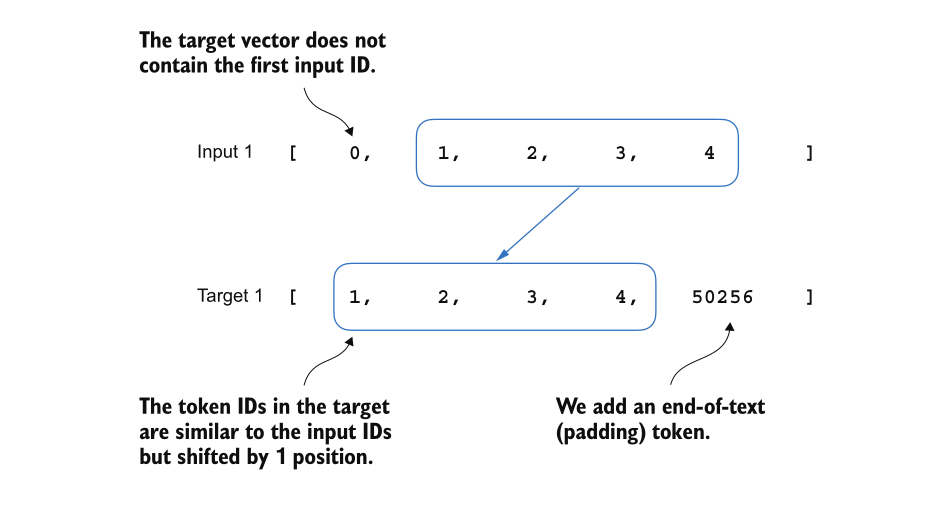

Let's update the function to also deal with targets

In [11]:
def collate(batch,pad_token_id=50256, device="cpu"):
    batch_max_length = max(len(item) + 1 for item in batch)
    inputs_list = []
    targets_list = []

    ## Padding
    for item in batch:
        new_item = item.copy()

        #That extra pad ensures the shifted targets are well-defined even for the last element.
        # If you didn’t add it, the final token wouldn’t have a target aligned with it.

        new_item += [pad_token_id] 

        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        inputs_list.append(inputs)
        targets_list.append(targets)

    inputs_tensor = torch.stack(inputs_list).to(device)
    target_tensor = torch.stack(targets_list).to(device)
    return inputs_tensor, target_tensor

We now will assign a -100 value to all padding tokens. This will ensure that they don't contribute to the training loss calculation. Note that we will retain one end-of-text token in the target list. We do this since this will allow the LLM to learn when to generate an end-of-text token in response to a query.

Besides this, we introduce an allowed_max_length parameter to optionally limit the length of the samples. This adjustment will be useful for datasets that exceed the 1,024-token context size supported by the GPT-2 model.

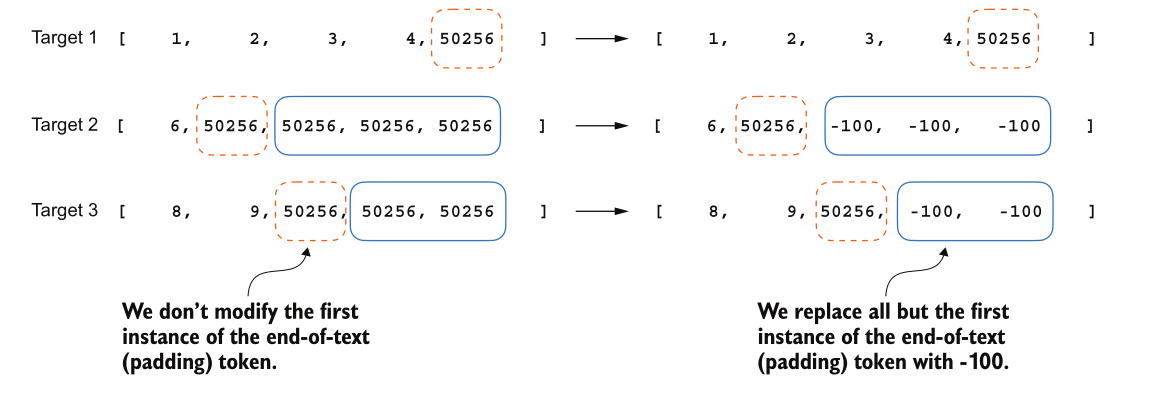

In [12]:
def collate(batch,pad_token_id=50256, ignore_index=-100, allowed_max_length=None, device="cpu"):
    batch_max_length = max(len(item) + 1 for item in batch)
    inputs_list = []
    targets_list = []

    ## Padding
    for item in batch:
        new_item = item.copy()

        #That extra pad ensures the shifted targets are well-defined even for the last element.
        # If you didn’t add it, the final token wouldn’t have a target aligned with it.

        new_item += [pad_token_id] 

        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))

        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()

        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]


        inputs_list.append(inputs)
        targets_list.append(targets)

    inputs_tensor = torch.stack(inputs_list).to(device)
    target_tensor = torch.stack(targets_list).to(device)
    return inputs_tensor, target_tensor

## DataLoader

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We want to reuse the chosen device setting in custom_collate, when we plug it into the `DataLoader`. We will use that partial function from Python's functools standard library to create a new version of the function with the device argument prefilled.  Partial creates a new function with partial application of the given arguments and keywords. Additionally, we set the allowed_max_length to 1024.

In [14]:
from functools import partial

#
customized_collate_fn = partial(
    collate,
    device=device,
    allowed_max_length=1024
)

In [15]:
from torch.utils.data import DataLoader
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

## For our dataset to have rows as dictionaries use data.to_dict(orient="records")

train_dataset = InstructionDataset(train_data.to_dict(orient="records"), tokenizer)
test_dataset = InstructionDataset(test_data.to_dict(orient="records"), tokenizer)
val_dataset = InstructionDataset(val_data.to_dict(orient="records"),tokenizer)

train_dataloader = DataLoader(train_dataset,
                              batch_size=8,
                              collate_fn=customized_collate_fn,
                              shuffle=True,
                              drop_last=True,
                              num_workers=0)

test_dataloader = DataLoader(test_dataset,
                              batch_size=8,
                              collate_fn=customized_collate_fn,
                              shuffle=True,
                              drop_last=True,
                              num_workers=0)

val_dataloader = DataLoader(val_dataset,
                              batch_size=8,
                              collate_fn=customized_collate_fn,
                              shuffle=True,
                              drop_last=True,
                              num_workers=0)

In [16]:
print("Train loader:")
for inputs, targets in train_dataloader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 510]) torch.Size([8, 510])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 730]) torch.Size([8, 730])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 634]) torch.Size([8, 634])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 834]) torch.Size([8, 834])
torch.Size([8, 541]) torch.Size([8, 541])
torch.Size([8, 820]) torch.Size([8, 820])
torch.Size([8, 515]) torch.Size([8, 515])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 762]) torch.Size([8, 762])
torch.Size([8, 501]) torch.Size([8, 501])
torch.Size([8, 435]) torch.Size([8, 435])
torch.Size([8, 389]) torch.Size([8, 389])
torch.Size([8, 862]) torch.Size([8, 862])
torch.Size([8, 956]) torch.Size([8, 956])
torch.Size([8, 675]) torch.Size([8, 675])
torch.Size([8, 1024]) torch.Size([8, 1024])
torch.Size([8, 744]) torch.Size([8, 744])
torch.Size([8, 660]) torch.Size([8, 660])
torch.Size([8, 588]) torch.Size([8, 588])
torch.Size([8, 985]) torch.Size([8, 985])
torch.Size

## Loading pretrained LLM

In [17]:
from src.utils.gpt_download import download_and_load_gpt2
from src.GPT_model import GPTModel
from src.utils.load_weights_into_gpt import *

BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True,
    "emb_dim": 1024, 
    "n_layers": 24,
    "n_heads": 16
}

settings, params = download_and_load_gpt2(model_size="355M", models_dir="gpt2"
)
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

2025-08-25 23:20:36.166984: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-25 23:20:36.219748: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-25 23:20:44.422004: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


GPTModel(
  (token_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer_block): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): NormalizationLayer()
      (norm2): NormalizationLayer()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
 

In [18]:
from src.training import (train_model,calculate_loss)

# Before training let's calculate the loss for the training and validation

model.to(device)

with torch.no_grad():
    train_loss = calculate_loss(train_dataloader, model, device, num_batches=5)
    val_loss = calculate_loss(val_dataloader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 2.338891077041626
Validation loss: 2.3508224964141844


In [19]:
import time
start_time = time.time()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)
num_epochs = 2

train_losses, val_losses, tokens_seen = train_model(model=model,
                                                    train_dataloader=train_dataloader,
                                                    test_dataloader=val_dataloader,
                                                    optimizer=optimizer,
                                                    device=device,
                                                    num_epochs=num_epochs,
                                                    eval_freq=5,
                                                    eval_iter=5,
                                                    )
end_time = time.time()
total_time = execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {total_time:.2f} minutes.")

OutOfMemoryError: CUDA out of memory. Tried to allocate 24.00 MiB. GPU 0 has a total capacity of 5.76 GiB of which 17.25 MiB is free. Including non-PyTorch memory, this process has 5.73 GiB memory in use. Of the allocated memory 5.53 GiB is allocated by PyTorch, and 105.29 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)